# Terceiro trabalho de processamento de imagens 2021.1

In [ ]:
import cv2 # processamento de imagens
import numpy as np # funções numéricas
import matplotlib.pyplot as plt # visualização
from PIL import Image  # processamento de imagens
import requests # requisições HTTP

# Montando o google drive, onde as imagens usadas foram colocadas (mesma pasta do notebook)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def url_to_image(url):
  """
  Faz o download da imagem, converte em np.array e abre usando o OpenCV
  """
  resp = requests.get(url, stream=True)
  image = Image.open(resp.raw)

  return image

lenna = np.array(url_to_image("https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"))

# convertendo para niveis de cinza
lenna = cv2.cvtColor(lenna, cv2.COLOR_RGB2GRAY)

## 1 - Implemente a operação de convolução para uma máscara de dimensão qualquer e ampliando a imagem de entrada com zeros.

In [ ]:
def convolution(img, conv_filter):

  """
  Calcula a convolução entre a imagem e o filtro conv_filter (que precisa ser uma matriz quadrada)
  """

  # se o filtro de convolução não for quadrado, para a função e retorna 0
  if conv_filter.shape[0] != conv_filter.shape[1]:
    print("O filtro precisa ter dimensões iguais")
    return -1

  # tamanho da janela usada será o mesmo do filtro de convolução dado como parametro
  window_size = conv_filter.shape[0]

  # quantos pixels de borda precisam ser adicionados
  pad_pixels = int((window_size-1)/2)

  # tamanho da janela para "andar" pela matriz é o mesmo que pad_pixels
  window_pixels = pad_pixels

  # adicionar bordas na imagem
  padded_img = np.pad(img, pad_pixels, constant_values = (0))
 
  # i e j precisam ser maiores que pad_pixels para só 
  # começarem a andar a partir da imagem original

  new_img = np.full(padded_img.shape, 0)
  for i in range(padded_img.shape[0] - pad_pixels):
    if i > pad_pixels - 1:
      for j in range(padded_img.shape[1] - pad_pixels):
        if j > pad_pixels - 1:
          window = padded_img[(i-window_pixels): (i+window_pixels+1), (j - window_pixels): (j+window_pixels+1)]
                    
          new_img[i,j] = (window*conv_filter).sum()

  return new_img

## 2 - Teste sua implementação com a máscara da média (box filter) 5 x 5 e compare o seu resultado com o obtido por uma API da biblioteca de processamento de imagem de sua escolha

In [ ]:
# filtro de média
def create_mean_filter(filter_size):
  return np.full((filter_size, filter_size), 1)/(filter_size**2)

five_mean = create_mean_filter(5)
five_mean

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]])

Text(0.5, 1.0, 'Função blur do OpenCV, que aplica o filtro de média')

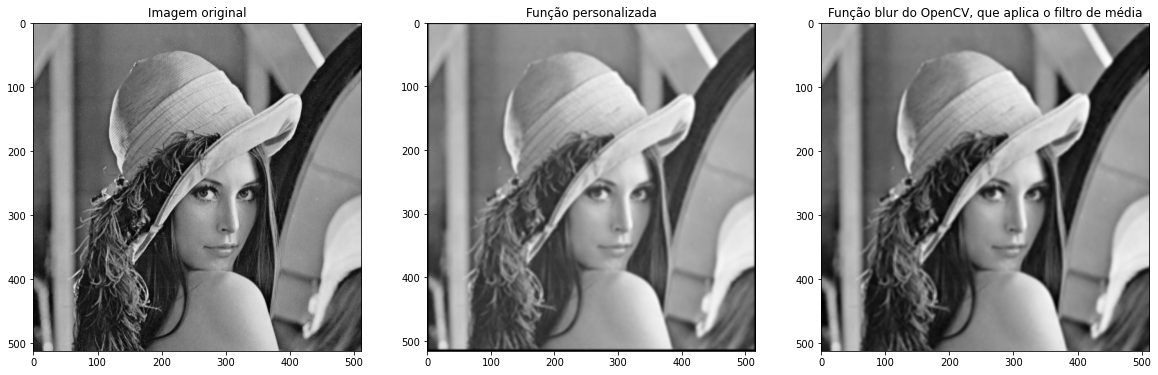

In [ ]:
mean_lenna = convolution(lenna, conv_filter = five_mean)
mean_opencv_lenna = cv2.blur(lenna, (5,5))
plt.figure(figsize = (20,10))

plt.subplot(1,3,1)
plt.imshow(lenna, cmap = "gray")
plt.title("Imagem original")

plt.subplot(1,3,2)
plt.imshow(mean_lenna, cmap = "gray")
plt.title("Função personalizada")

plt.subplot(1,3,3)
plt.imshow(mean_opencv_lenna, cmap = "gray")
plt.title("Função blur do OpenCV, que aplica o filtro de média")


As saídas parecem ser próximas uma da outra, mas a do OpenCV aparenta ter um pouco mais de contraste.

## 3 - Construa uma máscara 3 x 3 através da equação 𝑤(𝑥,𝑦)=𝑒−𝑥2+𝑦22𝜎2, usando os valores de x e y da figura abaixo e desvio σ = 3. Use a implementação geral do slide 5.

In [ ]:
sigma = 3
# inicializando a máscara
mask = np.full((3,3), 0, dtype = np.float)
# construção da máscara
for i in [-1,0,1]:
  for j in [-1,0,1]:
    w = np.exp(-(i**2 + j**2)/(2*sigma**2))
    mask[i+1,j+1] = w

mask

array([[0.89483932, 0.94595947, 0.89483932],
       [0.94595947, 1.        , 0.94595947],
       [0.89483932, 0.94595947, 0.89483932]])

## 4 - Aplique o filtro da mediana com máscaras 3 x 3 e 5 x 5 a uma imagem com ruído do tipo sal e pimenta (0 ou 255). Compare com a média.

Primeiro vamos criar a imagem com o ruído desejado:

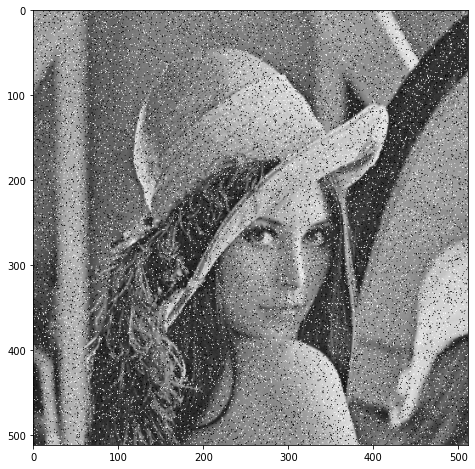

In [ ]:
import random
def sp_noise(image,prob):
    '''
    Adicionar o ruído sal e pimenta
    prob: probabilidade do ruído
    '''
    # inicializa a imagem de saída
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 

    #gera um ruído na imagem de 0 ou 255 dependendo da probabilidade
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

sp_lenna = sp_noise(lenna, prob = 0.05)
plt.figure(figsize = (8,8))
plt.imshow(sp_lenna, cmap = "gray");



Agora vamos aplicar os filtros requeridos:

Text(0.5, 1.0, 'Média 5x5')

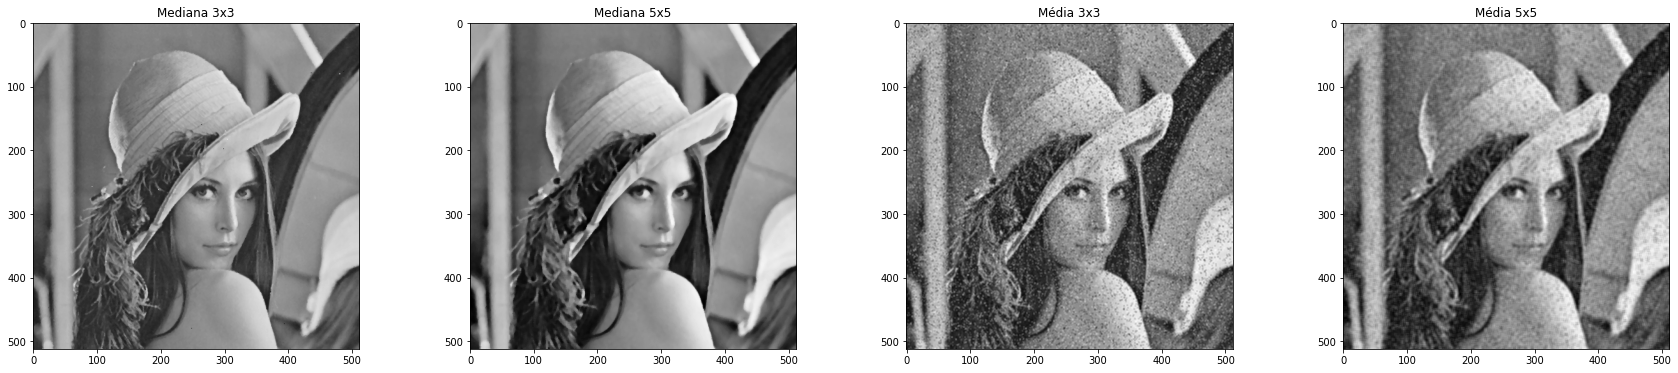

In [ ]:
# mediana com kernel 3x3
median_three = cv2.medianBlur(sp_lenna, 3)

# mediana com kernel 5x5
median_five = cv2.medianBlur(sp_lenna, 5)

# média com kernel 3x3
mean_three = cv2.blur(sp_lenna, (3,3))

# média com kernel 5x5
mean_five = cv2.blur(sp_lenna, (5,5))

plt.figure(figsize = (30,6))
plt.subplot(1,4,1)
plt.imshow(median_three, cmap = "gray")
plt.title("Mediana 3x3")

plt.subplot(1,4,2)
plt.imshow(median_five, cmap = "gray")
plt.title("Mediana 5x5")

plt.subplot(1,4,3)
plt.imshow(mean_three, cmap = "gray")
plt.title("Média 3x3")

plt.subplot(1,4,4)
plt.imshow(mean_five, cmap = "gray")
plt.title("Média 5x5")

A mediana removeu praticamente todo o ruído, enquanto que a média não o fez. Isso é esperado, já que como o ruído sal e pimenta apresenta valores máximos de pixel (255), a média dos pixels na região da janela é puxada para cima e, portanto, o ruído continua ao aplicar esse filtro. O filtro da mediana mantém usa um dos valores originais da imagem, preservando assim a imagem original (borrando levemente).        

## 5 - Aplique os filtros mín e máx com máscaras 3 x 3 e 5 x 5 para uma mesma imagem.

In [ ]:
def min_max_filter(img, window_size = 3, min_or_max = "min"):

  """
  Aplica os filtros minimo e máximo com máscaras de diferentes tamanhos
  """

  # quantos pixels de borda precisam ser adicionados
  pad_pixels = int((window_size-1)/2)

  # tamanho da janela para "andar" pela matriz é o mesmo que pad_pixels
  window_pixels = pad_pixels

  # adicionar bordas na imagem
  padded_img = np.pad(img, pad_pixels, constant_values = (0))
 
  # i e j precisam ser maiores que pad_pixels para só 
  # começarem a andar a partir da imagem original

  new_img = np.full(padded_img.shape, 0)
  for i in range(padded_img.shape[0] - pad_pixels):
    if i > pad_pixels - 1:
      for j in range(padded_img.shape[1] - pad_pixels):
        if j > pad_pixels - 1:
          window = padded_img[(i-window_pixels): (i+window_pixels+1), (j - window_pixels): (j+window_pixels+1)]
                    
          if min_or_max == "max":
            new_img[i,j] = np.max(window)
          elif min_or_max == "min":
            new_img[i,j] = np.min(window)
          else:
            print("min_or_max só pode ser 'min' ou 'max'.")
            return -1

  return new_img

In [ ]:
max_three = min_max_filter(lenna, window_size = 3, min_or_max="max")
min_three = min_max_filter(lenna, window_size = 3, min_or_max="min")

max_five = min_max_filter(lenna, window_size = 5, min_or_max="max")
min_five = min_max_filter(lenna, window_size = 5, min_or_max="min")

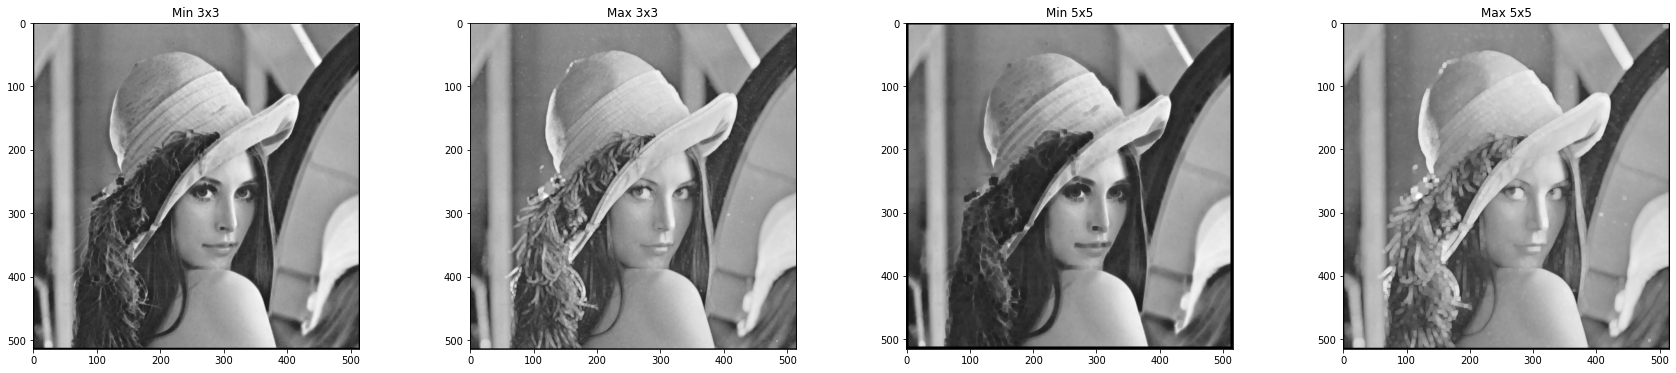

In [ ]:
plt.figure(figsize = (30,6))
plt.subplot(1,4,1)
plt.imshow(min_three, cmap = "gray")
plt.title("Min 3x3")

plt.subplot(1,4,2)
plt.imshow(max_three, cmap = "gray")
plt.title("Max 3x3")

plt.subplot(1,4,3)
plt.imshow(min_five, cmap = "gray")
plt.title("Min 5x5")

plt.subplot(1,4,4)
plt.imshow(max_five, cmap = "gray")
plt.title("Max 5x5");

## 6 - Aplique todos os filtros laplacianos do slide 13.

In [ ]:
# filtros do slide 13:
laplacian_first_neigh = np.array([[0, 1, 0],
                                  [1,-4, 1],
                                  [0, 1, 0]])

laplacian_diag= np.array([[1, 1, 1],
                          [1,-8, 1],
                          [1, 1, 1]])

neg_laplacian_first_neigh = np.array([[0,-1, 0],
                                      [-1, 4,-1],
                                      [0,-1, 0]])

neg_laplacian_diag = np.array([[-1,-1,-1],
                               [-1, 8,-1],
                               [-1,-1,-1]])

In [ ]:
first_lap = convolution(lenna, conv_filter = laplacian_first_neigh)

diag_lap = convolution(lenna, conv_filter = laplacian_diag)

neg_first_lap = convolution(lenna, conv_filter = neg_laplacian_first_neigh)

neg_diag_lap = convolution(lenna, conv_filter = neg_laplacian_diag)

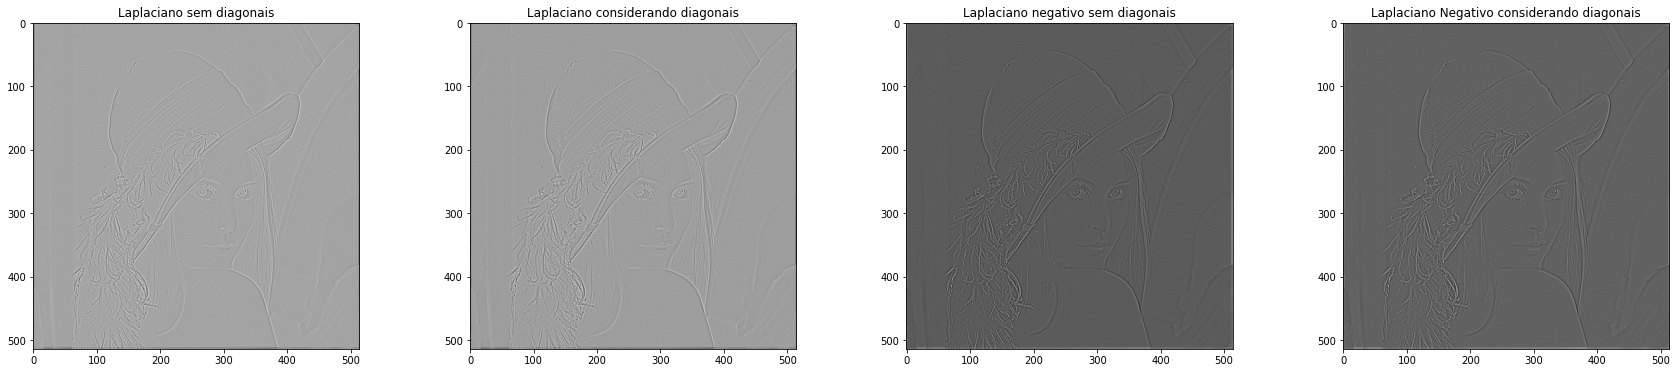

In [ ]:
plt.figure(figsize = (30,6))
plt.subplot(1,4,1)
plt.imshow(first_lap, cmap = "gray")
plt.title("Laplaciano sem diagonais")

plt.subplot(1,4,2)
plt.imshow(diag_lap, cmap = "gray")
plt.title("Laplaciano considerando diagonais")

plt.subplot(1,4,3)
plt.imshow(neg_first_lap, cmap = "gray")
plt.title("Laplaciano negativo sem diagonais")

plt.subplot(1,4,4)
plt.imshow(neg_diag_lap, cmap = "gray")
plt.title("Laplaciano Negativo considerando diagonais");

## 7 - Realize o aguçamento para a imagem da questão anterior para máscaras não e incluindo as diagonais.

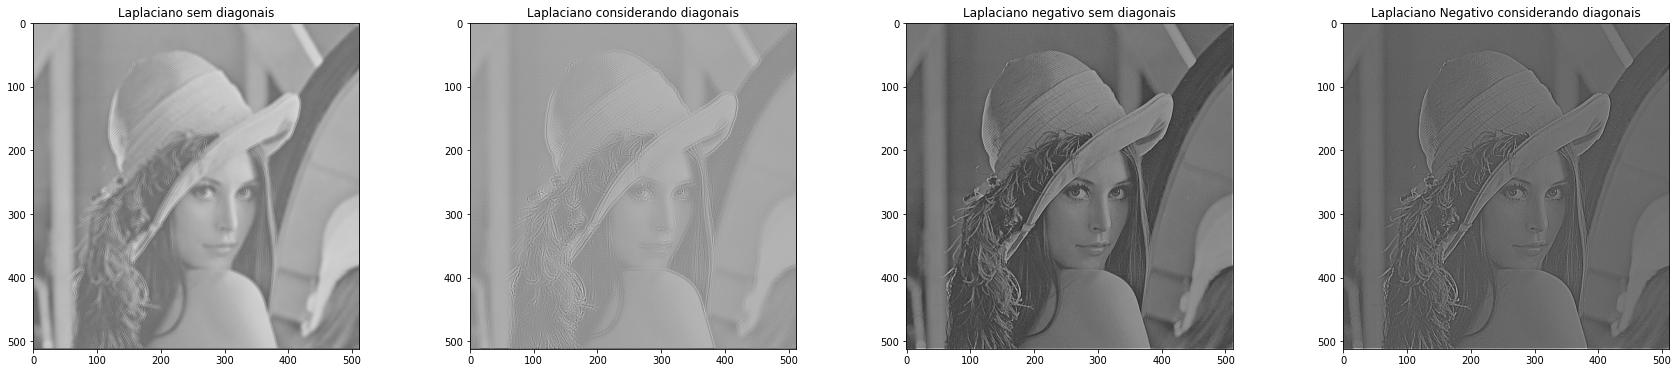

In [ ]:
first_lap_unpad = first_lap[1:-1, 1:-1].copy()
diag_lap_unpad = diag_lap[1:-1, 1:-1].copy()
neg_first_lap_unpad = neg_first_lap[1:-1, 1:-1].copy()
neg_diag_lap_unpad = neg_diag_lap[1:-1, 1:-1].copy()

plt.figure(figsize = (30,6))
plt.subplot(1,4,1)
plt.imshow(first_lap_unpad+lenna, cmap = "gray")
plt.title("Laplaciano sem diagonais")

plt.subplot(1,4,2)
plt.imshow(diag_lap_unpad+lenna, cmap = "gray")
plt.title("Laplaciano considerando diagonais")

plt.subplot(1,4,3)
plt.imshow(neg_first_lap_unpad+lenna, cmap = "gray")
plt.title("Laplaciano negativo sem diagonais")

plt.subplot(1,4,4)
plt.imshow(neg_diag_lap_unpad+lenna, cmap = "gray")
plt.title("Laplaciano Negativo considerando diagonais");

## 8 - Faça o aumento da nitidez e por alto-reforço (três valores de k) a uma imagem

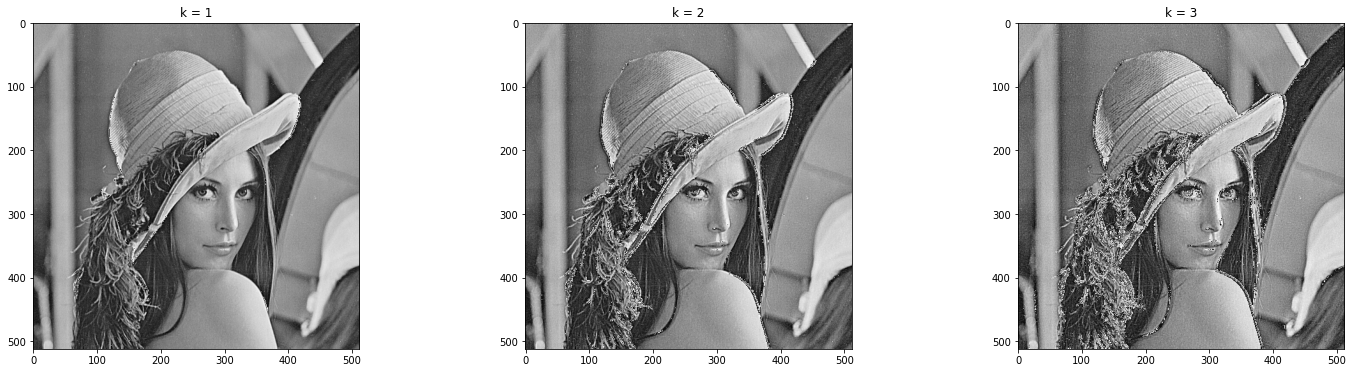

In [ ]:
# alto-reforço
def high_boost(img, k):
  # imagem borrada com um filtro gaussiano
  blurred_img  = cv2.GaussianBlur(img, (5,5), 5)

  # máscara
  mask = img - blurred_img

  # normalizar a mascara
  mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX)
  return img + k*mask, mask

plt.figure(figsize = (25,6))

i = 1
for k in [1, 2, 3]:
  filtered_img, _ = high_boost(lenna, k = k)
  plt.subplot(1,3,i)
  plt.imshow(filtered_img, cmap = "gray")
  plt.title("k = {}".format(k))
  i+=1


## 9 - Para uma imagem, aplique

### Operador gx de Sobel

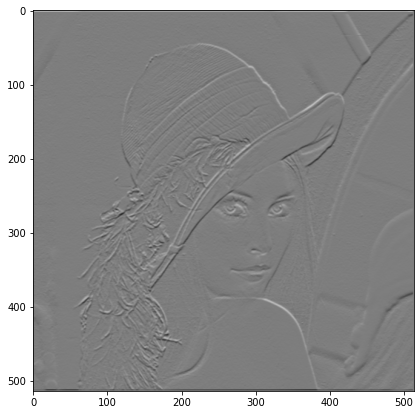

In [ ]:
gx_Sobel = np.array([[-1,-2,-1],
                     [0, 0, 0],
                     [1, 2, 1]])

imgx_sobel = convolution(lenna, gx_Sobel)
plt.figure(figsize = (7,7))
plt.imshow(imgx_sobel, cmap = "gray");

### Operador gy de Sobel

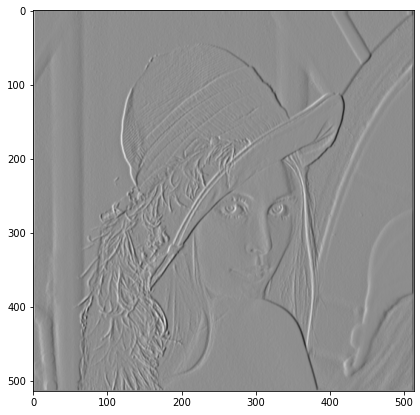

In [ ]:
gy_Sobel = np.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])

imgy_sobel = convolution(lenna, gy_Sobel)
plt.figure(figsize = (7,7))
plt.imshow(imgy_sobel, cmap = "gray");

### A imagem gradiente obtida das imagens resultados anteriores pelo módulo e pela sua aproximação.


#### Módulo

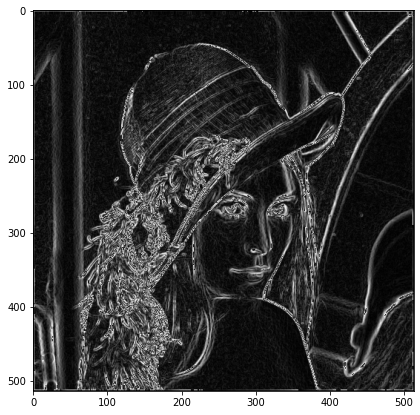

In [ ]:
M = np.sqrt(np.square(imgx_sobel) + np.square(imgy_sobel)) #Eq. 3.6-11 do Gonzalez 3ed

plt.figure(figsize = (7,7))
plt.imshow(np.uint8(M), cmap = "gray");

#### Aproximação

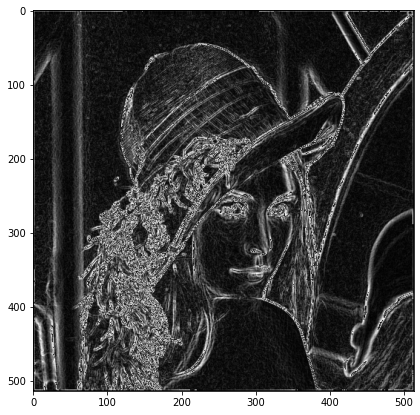

In [ ]:
M_approx = np.abs(imgx_sobel) + np.abs(imgy_sobel) # Eq. 3.6-12 do Gonzalez 3d

plt.figure(figsize = (7,7))
plt.imshow(np.uint8(M_approx), cmap = "gray");

### Filtro diagonal gx de Roberts

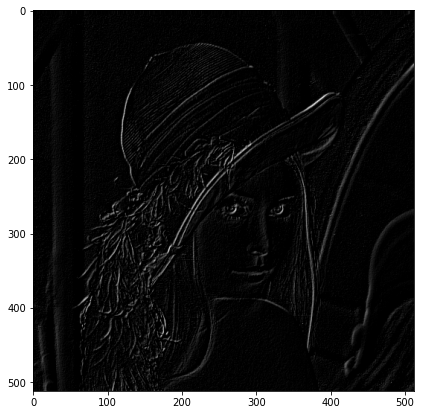

In [ ]:
gx = np.array([[-1,0],
               [0,1]])
plt.figure(figsize = (7,7))

# como o filtro possui tamanh par, eu usei a função filter2D do OpenCV
# já que a `convolution` só suporta tamanhos ímpares
gx_img = cv2.filter2D(lenna, cv2.CV_8U, gx)
plt.imshow(gx_img, cmap = "gray")

### Filtro diagonal gy de Roberts

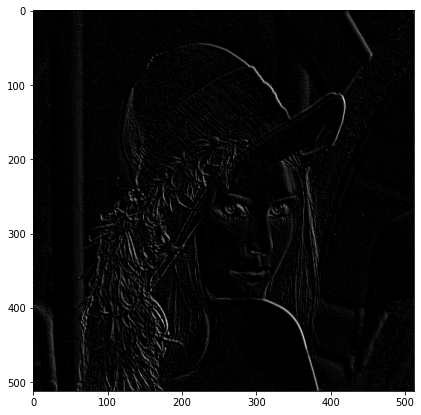

In [ ]:
gy = np.array([[0,-1],
               [1, 0]])
plt.figure(figsize = (7,7))

# como o filtro possui tamanh par, eu usei a função filter2D do OpenCV
# já que a `convolution` só suporta tamanhos ímpares
gy_img = cv2.filter2D(lenna, cv2.CV_8U, gy)
plt.imshow(gy_img, cmap = "gray")

### A imagem gradiente obtida das imagens resultados anteriores pelo módulo e pela sua aproximação.



#### Módulo

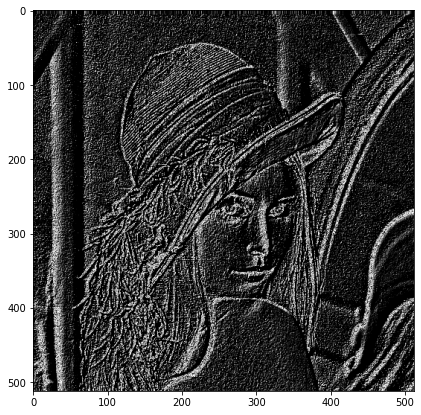

In [ ]:
M = np.sqrt(np.square(gx_img) + np.square(gx_img)) #Eq. 3.6-11 do Gonzalez 3ed

plt.figure(figsize = (7,7))
plt.imshow(np.uint8(M), cmap = "gray");

#### Aproximação

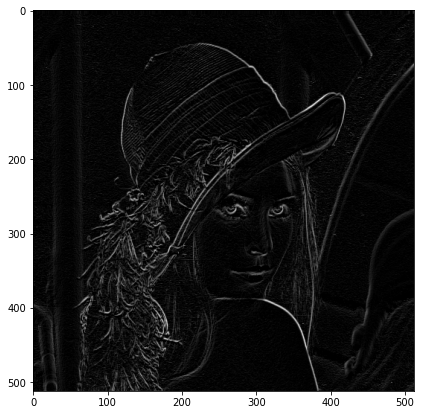

In [ ]:
M_approx = np.abs(gx_img) + np.abs(gy_img)

plt.figure(figsize = (7,7))
plt.imshow(np.uint8(M_approx), cmap = "gray");

## 10 - Aplique o procedimento utilizado nos slides 21 e 22 à mesma imagem (Fig0343(a)(skeleton_orig).tif) ou a outra que contenha uma estrutura óssea a ser salientada.

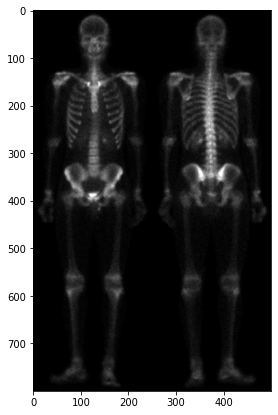

In [ ]:
skeleton = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/Fig0343(a)(skeleton_orig).tif"))
plt.figure(figsize = (7,7))
plt.imshow(skeleton, cmap = "gray");

### Métodos do slide 21

In [ ]:
# laplaciano da imagem
lap_skel = convolution(skeleton, laplacian_diag)

# soma do laplaciano com a imagem original
# o fatiamento de lap_skel é para remover os 0 do padding
intermediate_skel = lap_skel[1:-1, 1:-1] + skeleton

# gradiente de Sobel da imagem original
sobel_skel =  cv2.add(convolution(skeleton, gx_Sobel)[1:-1, 1:-1], convolution(skeleton, gy_Sobel)[1:-1, 1:-1])

Text(0.5, 1.0, 'Gradiente de Sobel da imagem original')

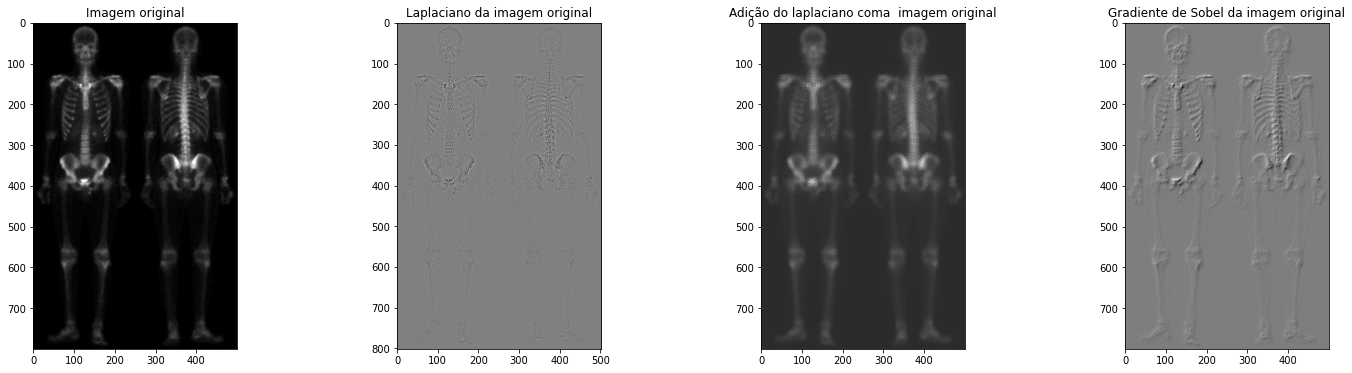

In [ ]:
plt.figure(figsize = (25,6))
plt.subplot(1,4,1)
plt.imshow(skeleton, cmap = "gray")
plt.title("Imagem original")

plt.subplot(1,4,2)
plt.imshow(lap_skel, cmap = "gray")
plt.title("Laplaciano da imagem original")

plt.subplot(1,4,3)
plt.imshow(intermediate_skel, cmap = "gray")
plt.title("Adição do laplaciano coma  imagem original")

plt.subplot(1,4,4)
plt.imshow(sobel_skel, cmap = "gray")
plt.title("Gradiente de Sobel da imagem original")

### Métodos do slide 22

In [ ]:
# filtro de média na imagem de sobel
mean_sobel = convolution(sobel_skel, five_mean)

# produto da imagem de Sobel com filtro de media pela imagem com o laplaciano
prod_sobel_lap = mean_sobel[2:-2,2:-2]*intermediate_skel

# soma da imagem original com a anterior
sum_orig_prod = prod_sobel_lap + skeleton

# transformação em portência
def gamma_transform(img, c = 1, gamma = 0.05):
  # usa a transformada gamma com a equação que está no livro do Gonzalez
  gamma_img = c * np.power(img,gamma)
  # coloca a imagem entre os valores de 0 e 255
  gamma_img = cv2.normalize(gamma_img, dst = None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX) 
  return gamma_img

trans_img = gamma_transform(sum_orig_prod, gamma = 1.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in power
  del sys.path[0]


Text(0.5, 1.0, 'Transformação de potência')

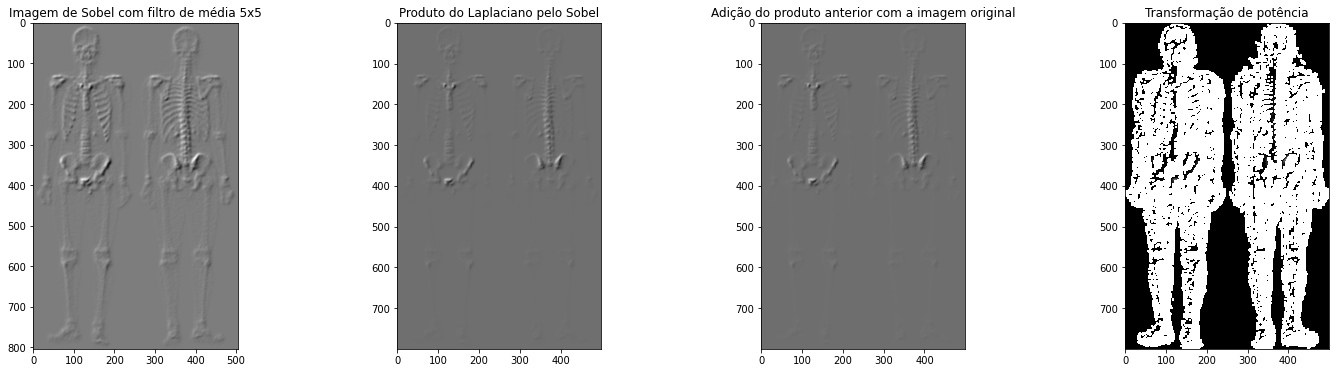

In [ ]:
plt.figure(figsize = (25,6))
plt.subplot(1,4,1)
plt.imshow(mean_sobel, cmap = "gray")
plt.title("Imagem de Sobel com filtro de média 5x5")

plt.subplot(1,4,2)
plt.imshow(prod_sobel_lap, cmap = "gray")
plt.title("Produto do Laplaciano pelo Sobel")

plt.subplot(1,4,3)
plt.imshow(sum_orig_prod, cmap = "gray")
plt.title("Adição do produto anterior com a imagem original")

plt.subplot(1,4,4)
plt.imshow(trans_img, cmap = "gray")
plt.title("Transformação de potência")